In [89]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
from timezonefinder import TimezoneFinder
import pytz

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import random

# set cwd to src
os.chdir('../src')
from utils import normal

### Load Data

In [90]:
# X = pd.read_csv('../results/csvs/training_data_2022-11_to_2023-03.csv')
# X = pd.read_csv('../results/csvs/corrected_training_data_2022-11_to_2023-03.csv')
# X = pd.read_csv('../results/csvs/newest_training_data.csv')
X = pd.read_csv('../results/csvs/training_data_with_n=8.csv')
y = pd.read_csv('../data/IrvineSpectrumCenter_parking_2022-11_to_2023-03.csv')
lot_ids = list(X['pk_lot'].unique())
y = y[y['pk_lot'].isin(lot_ids)]

# remove the -8:00 from the end of the timestamp. I didn't mean to add it in the first place
# X['timestamp'] = X['timestamp'].apply(lambda x: x[:-6])
# X['timestamp'] = pd.to_datetime(X['timestamp'])
# X['timestamp'] = X['timestamp'].dt.tz_localize('UTC')

# convert timestamp to datetime when the rows have different timezones
X['timestamp'] = pd.to_datetime(X['timestamp'], utc=True)
X['timestamp'] = X['timestamp'].dt.tz_convert('US/Pacific')

# sort by timestamp
X = X.sort_values(by=['timestamp'])
X['timestamp'] = X['timestamp'].dt.tz_convert('US/Pacific')

y['dt_start_date'] = pd.to_datetime(y['dt_start_date'])
y['dt_start_date'] = y['dt_start_date'].dt.round('h')
y['dt_start_date'] = y['dt_start_date'].dt.tz_convert('US/Pacific')
y.drop(columns=['dt_end_date', 'pk_lot_alias', 'f_occupancy_rank'], inplace=True)
X = X.sort_values(by=['timestamp'])
y = y.sort_values(by=['dt_start_date'])
display(X.head(10))
display(y.head(10))

,timestamp,pk_lot,wasserstein,avg_hotspot_distance,avg_log_prob,weighted_hotspot_distance,weighted_log_prob,probe_count,nth_car_time
0,2022-11-01 00:00:00-07:00,329825,0.800952,0.011937,14.136364,0.013372,14.045293,0,0 days 06:15:23
1,2022-11-01 00:00:00-07:00,375750,1.172842,0.021085,14.036420,0.021888,14.246697,0,0 days 05:45:55
2,2022-11-01 00:00:00-07:00,380308,0.893385,0.025210,13.634860,0.027365,13.617540,0,0 days 06:55:57
3,2022-11-01 00:00:00-07:00,381380,0.937652,0.016501,13.869297,0.015935,13.947039,0,0 days 05:29:44
4,2022-11-01 00:00:00-07:00,381381,0.612691,0.029476,13.374122,0.022544,13.505269,0,0 days 05:04:56
5,2022-11-01 00:00:00-07:00,387459,1.223881,0.012936,13.971685,0.012323,13.975613,0,0 days 06:50:54
8,2022-11-01 01:00:00-07:00,380308,0.768864,0.025210,13.634860,0.027365,13.617540,0,0 days 07:55:57
6,2022-11-01 01:00:00-07:00,329825,0.810794,0.011937,14.136364,0.013372,14.045293,0,0 days 07:15:23
7,2022-11-01 01:00:00-07:00,375750,1.103204,0.021085,14.036420,0.021888,14.246697,0,0 days 06:45:55
10,2022-11-01 01:00:00-07:00,381381,0.667591,0.029476,13.374122,0.022544,13.505269,0,0 days 06:04:56


,dt_start_date,i_avail,i_occ,f_pct_occ,pk_lot,location,geometry
0,2022-11-01 00:00:00-07:00,138,NaN,31.0,381380,POINT(-117.74155545543 33.6509462183159),"MULTIPOLYGON (((-117.741726902 33.650923943, -..."
1,2022-11-01 00:00:00-07:00,1171,NaN,18.0,387459,POINT(-117.739167661281 33.6474458340334),"MULTIPOLYGON (((-117.739180228 33.648147941, -..."
2,2022-11-01 00:00:00-07:00,197,NaN,18.0,329825,POINT(-117.742706 33.6479646),"MULTIPOLYGON (((-117.74335 33.64835, -117.7420..."
3,2022-11-01 00:00:00-07:00,212,NaN,5.0,375750,POINT(-117.7398482 33.6484276),"MULTIPOLYGON (((-117.74027 33.64827, -117.7402..."
4,2022-11-01 00:00:00-07:00,769,NaN,10.0,380308,POINT(-117.744096689923 33.6488428962109),"MULTIPOLYGON (((-117.744053131 33.649582084, -..."
5,2022-11-01 00:00:00-07:00,1434,NaN,25.0,381381,POINT(-117.743547574184 33.6523127479216),"MULTIPOLYGON (((-117.743790442 33.653241372, -..."
6,2022-11-01 01:00:00-07:00,138,NaN,31.0,381380,POINT(-117.74155545543 33.6509462183159),"MULTIPOLYGON (((-117.741726902 33.650923943, -..."
7,2022-11-01 01:00:00-07:00,1171,NaN,18.0,387459,POINT(-117.739167661281 33.6474458340334),"MULTIPOLYGON (((-117.739180228 33.648147941, -..."
8,2022-11-01 01:00:00-07:00,197,NaN,18.0,329825,POINT(-117.742706 33.6479646),"MULTIPOLYGON (((-117.74335 33.64835, -117.7420..."
9,2022-11-01 01:00:00-07:00,212,NaN,5.0,375750,POINT(-117.7398482 33.6484276),"MULTIPOLYGON (((-117.74027 33.64827, -117.7402..."


In [91]:
# convert the nth_car_time to an integer giving minutes in duration
X['nth_car_time'] = pd.to_timedelta(X['nth_car_time'])
X['nth_car_time'] = X['nth_car_time'].dt.total_seconds() // 60
X.head(10)

,timestamp,pk_lot,wasserstein,avg_hotspot_distance,avg_log_prob,weighted_hotspot_distance,weighted_log_prob,probe_count,nth_car_time
0,2022-11-01 00:00:00-07:00,329825,0.800952,0.011937,14.136364,0.013372,14.045293,0,375.0
1,2022-11-01 00:00:00-07:00,375750,1.172842,0.021085,14.036420,0.021888,14.246697,0,345.0
2,2022-11-01 00:00:00-07:00,380308,0.893385,0.025210,13.634860,0.027365,13.617540,0,415.0
3,2022-11-01 00:00:00-07:00,381380,0.937652,0.016501,13.869297,0.015935,13.947039,0,329.0
4,2022-11-01 00:00:00-07:00,381381,0.612691,0.029476,13.374122,0.022544,13.505269,0,304.0
5,2022-11-01 00:00:00-07:00,387459,1.223881,0.012936,13.971685,0.012323,13.975613,0,410.0
8,2022-11-01 01:00:00-07:00,380308,0.768864,0.025210,13.634860,0.027365,13.617540,0,475.0
6,2022-11-01 01:00:00-07:00,329825,0.810794,0.011937,14.136364,0.013372,14.045293,0,435.0
7,2022-11-01 01:00:00-07:00,375750,1.103204,0.021085,14.036420,0.021888,14.246697,0,405.0
10,2022-11-01 01:00:00-07:00,381381,0.667591,0.029476,13.374122,0.022544,13.505269,0,364.0


Check that we have adequate data coverage (temporally speaking)

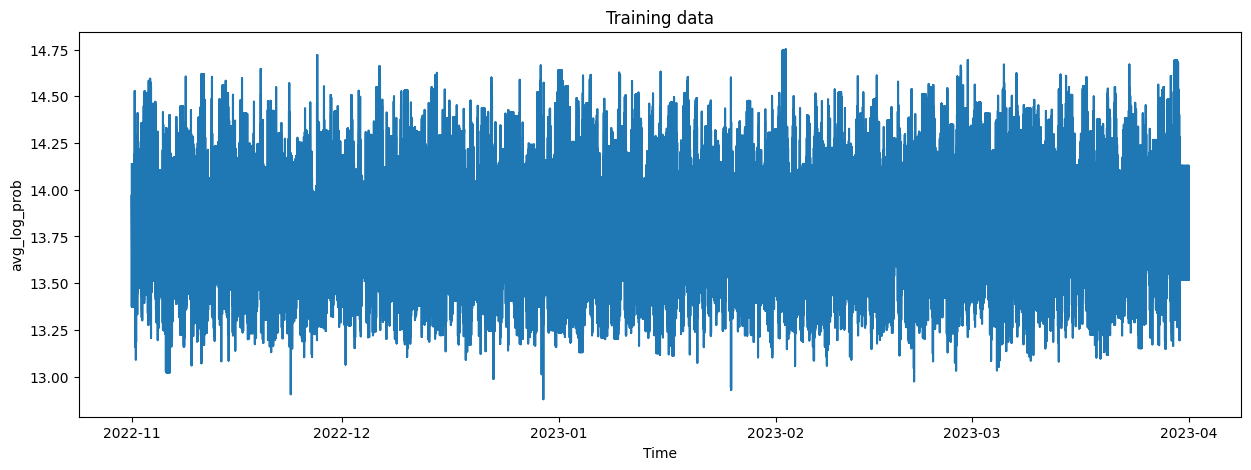

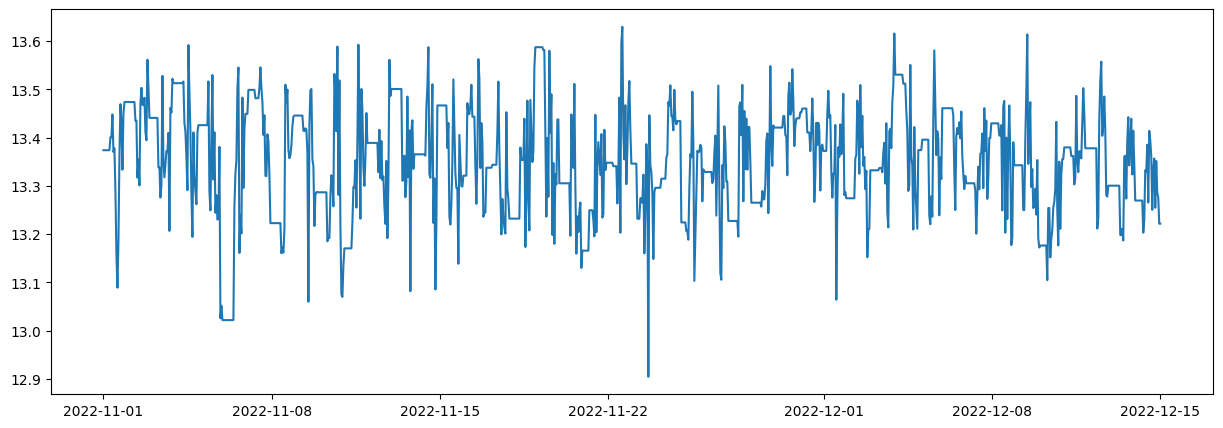

In [92]:
# plot the hours for which we have some data
plt.figure(figsize=(15, 5))
plt.plot(X['timestamp'], X['avg_log_prob'])
plt.xlabel('Time')
plt.ylabel('avg_log_prob')
plt.title('Training data')
plt.show()

plt.figure(figsize=(15, 5))
df = X[(X['timestamp'] <= '2022-12-15') & (X['pk_lot'] == 381381)].copy()
# sort by timestamp
df = df.sort_values(by=['timestamp'])
plt.plot(df['timestamp'], df['avg_log_prob'])
plt.show()

Prepare the ground truth and join it with the training data

In [93]:
y['timestamp'] = y['dt_start_date'].dt.round('h', ambiguous='NaT')
agg_dict = {'f_pct_occ': 'mean', 'i_avail': 'mean', 'i_occ': 'mean',
            'location': 'first', 'geometry': 'first',}
y = y.groupby(['timestamp', 'pk_lot']).agg(agg_dict).reset_index()
display(y)

,timestamp,pk_lot,f_pct_occ,i_avail,i_occ,location,geometry
0,2022-11-01 00:00:00-07:00,329825,18.0,197.0,NaN,POINT(-117.742706 33.6479646),"MULTIPOLYGON (((-117.74335 33.64835, -117.7420..."
1,2022-11-01 00:00:00-07:00,375750,5.0,212.0,NaN,POINT(-117.7398482 33.6484276),"MULTIPOLYGON (((-117.74027 33.64827, -117.7402..."
2,2022-11-01 00:00:00-07:00,380308,10.0,769.0,NaN,POINT(-117.744096689923 33.6488428962109),"MULTIPOLYGON (((-117.744053131 33.649582084, -..."
3,2022-11-01 00:00:00-07:00,381380,31.0,138.0,NaN,POINT(-117.74155545543 33.6509462183159),"MULTIPOLYGON (((-117.741726902 33.650923943, -..."
4,2022-11-01 00:00:00-07:00,381381,25.0,1434.0,NaN,POINT(-117.743547574184 33.6523127479216),"MULTIPOLYGON (((-117.743790442 33.653241372, -..."
...,...,...,...,...,...,...,...
18511,2023-03-31 00:00:00-07:00,375750,17.0,184.0,NaN,POINT(-117.7398482 33.6484276),"MULTIPOLYGON (((-117.74027 33.64827, -117.7402..."
18512,2023-03-31 00:00:00-07:00,380308,23.0,706.0,NaN,POINT(-117.744096689923 33.6488428962109),"MULTIPOLYGON (((-117.744053131 33.649582084, -..."
18513,2023-03-31 00:00:00-07:00,381380,40.0,119.0,NaN,POINT(-117.74155545543 33.6509462183159),"MULTIPOLYGON (((-117.741726902 33.650923943, -..."
18514,2023-03-31 00:00:00-07:00,381381,24.0,1680.0,NaN,POINT(-117.743547574184 33.6523127479216),"MULTIPOLYGON (((-117.743790442 33.653241372, -..."


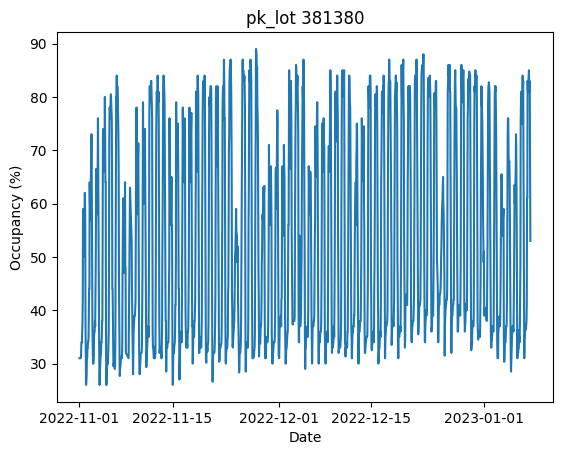

In [94]:
# plot f_pct_occ vs. timestamp for y for first week for random lot
lot_id = np.random.choice(lot_ids)
week_df = y[(y['timestamp'] < '2023-01-08') & (y['pk_lot'] == lot_id)]
plt.plot(week_df['timestamp'], week_df['f_pct_occ'])
plt.xlabel('Date')
plt.ylabel('Occupancy (%)')
plt.title(f'pk_lot {lot_id}')
plt.show()

In [95]:
print(X.shape)
print(y.shape)

# join X and y on timestamp and pk_lot
df = pd.merge(X, y, on=['timestamp', 'pk_lot'], how='inner')
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['is_weekend'] = df['timestamp'].dt.dayofweek >= 5

print(df.shape)
display(df.head(2))

(21732, 9)
(18516, 7)
(18516, 17)


,timestamp,pk_lot,wasserstein,avg_hotspot_distance,avg_log_prob,weighted_hotspot_distance,weighted_log_prob,probe_count,nth_car_time,f_pct_occ,i_avail,i_occ,location,geometry,hour,day_of_week,is_weekend
0,2022-11-01 00:00:00-07:00,329825,0.800952,0.011937,14.136364,0.013372,14.045293,0,375.0,18.0,197.0,NaN,POINT(-117.742706 33.6479646),"MULTIPOLYGON (((-117.74335 33.64835, -117.7420...",0,1,False
1,2022-11-01 00:00:00-07:00,375750,1.172842,0.021085,14.036420,0.021888,14.246697,0,345.0,5.0,212.0,NaN,POINT(-117.7398482 33.6484276),"MULTIPOLYGON (((-117.74027 33.64827, -117.7402...",0,1,False


### Basic linear regression

In [96]:


# # input_features = ['wasserstein', 'avg_hotspot_distance', 'hour', 'day_of_week']
# input_features = ['wasserstein', 'avg_hotspot_distance', 'day_of_week']

# X = df[input_features].values
# y = df['f_pct_occ'].values
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# model = LinearRegression()

# # train model
# model.fit(X_train, y_train)

# # evaluate model
# y_pred = model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# print(f'MSE: {mse}')


In [97]:
# # plot each input feature vs. f_pct_occ
# for feat in input_features:
#     plt.scatter(df[feat], df['f_pct_occ'], alpha=0.3)
#     plt.xlabel(feat)
#     plt.ylabel('f_pct_occ')
#     plt.title(f'{feat} vs. f_pct_occ')
#     plt.show()

In [98]:
# # plot predictions vs. true values
# plt.scatter(y_test, y_pred)
# # line of best fit
# m, b = np.polyfit(y_test, y_pred, 1)
# plt.plot(y_test, m*y_test + b, color='red')
# plt.plot([0, 100], [0, 100], color='black', linestyle='--')
# plt.xlim(0, 100)
# plt.ylim(0, 100)

# plt.xlabel('True')
# plt.ylabel('Predicted')
# plt.title('Linear Regression Occupancy (%)')
# plt.show()

# # plot feature importance
# importance = model.coef_
# plt.bar([x for x in range(len(importance))], importance)
# plt.xticks(ticks=[x for x in range(len(importance))], labels=input_features)
# plt.title('Feature Importance')

# plt.show()

In [99]:
# # plot the predicted time series
# # get the first week of data for a random lot
# lot_id = np.random.choice(lot_ids)
# week_df = df[(df['timestamp'] < '2023-01-08') & (df['pk_lot'] == lot_id)]
# X = week_df[input_features].values
# X = scaler.transform(X)
# y_pred = model.predict(X)

# plt.plot(week_df['timestamp'], week_df['f_pct_occ'], label='True')
# plt.plot(week_df['timestamp'], y_pred, label='Predicted')
# plt.xlabel('Date')
# plt.ylabel('Occupancy (%)')
# plt.title(f'pk_lot {lot_id}')
# plt.legend()
# plt.show()

### Train a machine learning model to predict the occupancy of a parking lot

At a given time, the model will use metrics about the distribution of trips at that time (call it $\^{X}$) compared to the aggregated distribution of trips over a larger time interval (call it $X$).

We use a shallow multi layered perceptron first with few inputs
- Wasserstein distance between $X$ and $\^{X}$
- Avg distance of cars to their nearest hotspot

In [100]:
# # set directory to src
# os.chdir('../src')

# from model import Model

In [101]:
# input_features = ['wasserstein', 'avg_hotspot_distance', 'hour', 'day_of_week']

# X = df[input_features].values
# y = df['f_pct_occ'].values
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# model = Model(input_dim=len(input_features))
# model.fit(X_train, y_train, epochs=1000, batch_size=32)

# y_pred = model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# print(f'MSE: {mse}')

In [102]:
# # plot predictions vs. true values
# plt.scatter(y_test, y_pred)
# # line of best fit
# m, b = np.polyfit(y_test, y_pred, 1)
# plt.plot(y_test, m*y_test + b, color='red')
# plt.plot([0, 100], [0, 100], color='black', linestyle='--')
# plt.xlim(0, 100)
# plt.ylim(0, 100)
# plt.xlabel('True')
# plt.ylabel('Predicted')
# plt.title('Neural Network Occupancy (%)')
# plt.show()

### Lets try a Random Forest

In [103]:
# input_features = ['wasserstein', 'avg_hotspot_distance', 'day_of_week']
# input_features = ['wasserstein', 'avg_hotspot_distance', 'avg_log_prob', 'hour', 'day_of_week']
# input_features = ['hour', 'day_of_week']
# input_features = ['wasserstein', 'day_of_week', 'hour', 'weighted_hotspot_distance', 'weighted_log_prob']
# output_feature = 'f_pct_occ' #'i_avail'

# X = df[input_features].values
# y = df[output_feature].values
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# model = RandomForestRegressor(n_estimators=2000, max_depth=50)
# model.fit(X_train, y_train)

# y_pred = model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# print(f'MSE: {mse}')

# # r^2 value between y_test and y_pred
# r2 = r2_score(y_test, y_pred)
# print(f'R^2: {r2}')

In [104]:
# # visualize results
# plt.scatter(y_test, y_pred)
# # line of best fit
# m, b = np.polyfit(y_test, y_pred, 1)
# plt.plot(y_test, m*y_test + b, color='red')
# max_val = max(max(y_test), max(y_pred))
# plt.plot([0, max_val], [0, max_val], color='black', linestyle='--')
# if output_feature == 'f_pct_occ':
#     plt.xlim(0, 100)
#     plt.ylim(0, 100)
# plt.xlabel('True')
# plt.ylabel('Predicted')
# plt.title(f'Random Forest {output_feature}')
# plt.show()

# # plot feature importance
# fig = plt.figure(figsize=(15, 5))
# importance = model.feature_importances_
# plt.bar([x for x in range(len(importance))], importance)
# plt.xticks(ticks=[x for x in range(len(importance))], labels=input_features)
# plt.title('Feature Importance')
# plt.show()

In [105]:
# # plot the predicted time series
# # get the first week of data for a random lot
# lot_id = np.random.choice(lot_ids)
# start_day = random.randint(1, 29)
# end_day = random.randint(start_day + 1, min(start_day + 13, 30))
# start_date = '2022-12-' + str(start_day)
# end_date = '2023-01-' + str(end_day)
# week_df = df[(df['timestamp'] < end_date) & (start_date < df['timestamp']) & (df['pk_lot'] == lot_id)]
# # sort week_df
# week_df = week_df.sort_values(by=['timestamp'])
# week = week_df[input_features].values
# week = scaler.transform(week)
# week_pred = model.predict(week)

# print(f'Predicted time series for pk_lot {lot_id} from {start_date} to {end_date}')

# fig = plt.figure(figsize=(12, 5))
# plt.plot(week_df['timestamp'], week_df[output_feature], label='True')
# plt.plot(week_df['timestamp'], week_pred, label='Predicted')
# plt.xlabel('Date')
# plt.ylabel(output_feature)
# plt.title(f'pk_lot {lot_id}')
# plt.legend()
# plt.show()

### Curate the training data
1. Find “typical” occupancy for each (pk_lot, hour, day of week) pair

2. Calculate the deltas (difference between actual occupancy and typical occupancy). The deltas are probably distributed with a strong mode around 0. We want the deltas to be more normally distributed in the training data.

3. Finally, reshape the distribution by applying a weighting to each data point and then randomly resampling to get a new set of training data.

In [106]:
df.head(1)

,timestamp,pk_lot,wasserstein,avg_hotspot_distance,avg_log_prob,weighted_hotspot_distance,weighted_log_prob,probe_count,nth_car_time,f_pct_occ,i_avail,i_occ,location,geometry,hour,day_of_week,is_weekend
0,2022-11-01 00:00:00-07:00,329825,0.800952,0.011937,14.136364,0.013372,14.045293,0,375.0,18.0,197.0,NaN,POINT(-117.742706 33.6479646),"MULTIPOLYGON (((-117.74335 33.64835, -117.7420...",0,1,False


,pk_lot,hour,day_of_week,typical_f_pct_occ,hour_of_week
0,329825,0,0,24.950700,0
7,329825,1,0,20.986717,1
14,329825,2,0,22.033333,2
21,329825,3,0,22.500000,3
28,329825,4,0,22.346491,4
...,...,...,...,...,...
979,387459,19,6,53.293651,163
986,387459,20,6,47.498611,164
993,387459,21,6,40.352564,165
1000,387459,22,6,31.897368,166


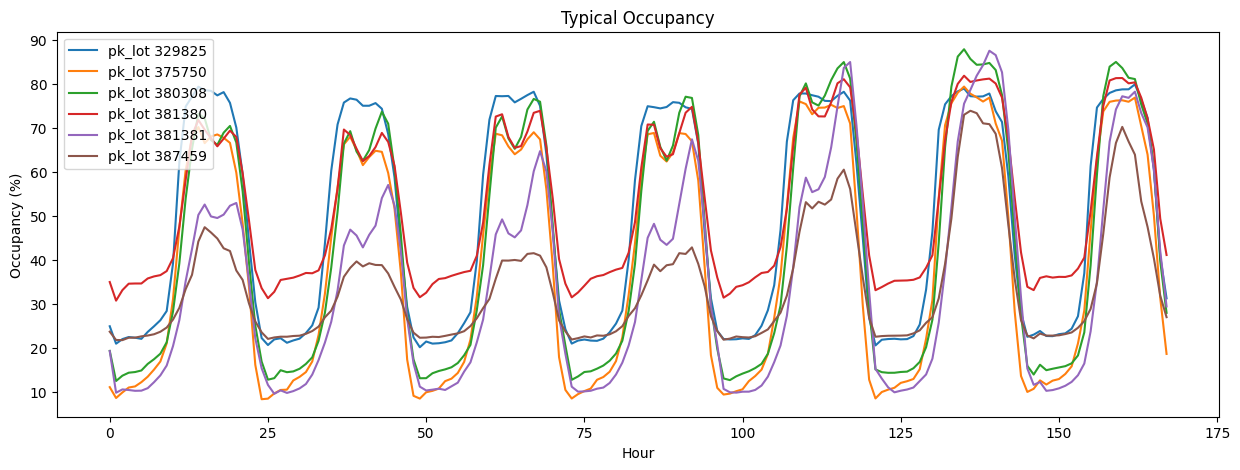

In [107]:
# typical occupancy for each (lot, hour, day_of_week) tuple
typical_occupancy = df.groupby(['pk_lot', 'hour', 'day_of_week'])['f_pct_occ'].mean().reset_index()
typical_occupancy['hour_of_week'] = typical_occupancy['day_of_week'] * 24 + typical_occupancy['hour']
typical_occupancy = typical_occupancy.sort_values(by=['pk_lot', 'hour_of_week'])
typical_occupancy = typical_occupancy.rename(columns={'f_pct_occ': 'typical_f_pct_occ'})
display(typical_occupancy)

# make a plot of each lot's typical occupancy
plt.figure(figsize=(15, 5))
for lot_id in lot_ids:
    lot_df = typical_occupancy[typical_occupancy['pk_lot'] == lot_id]
    plt.plot(lot_df['hour_of_week'], lot_df['typical_f_pct_occ'], label=f'pk_lot {lot_id}')
plt.xlabel('Hour')
plt.ylabel('Occupancy (%)')
plt.title('Typical Occupancy')
plt.legend()
plt.show()

In [108]:
# merge the typical_occupancy to the df
orig_size = df.shape[0]
df = pd.merge(df, typical_occupancy, on=['pk_lot', 'hour', 'day_of_week'], how='inner')
assert orig_size == df.shape[0]
display(df.head(1))
df['delta'] = df['f_pct_occ'] - df['typical_f_pct_occ']

,timestamp,pk_lot,wasserstein,avg_hotspot_distance,avg_log_prob,weighted_hotspot_distance,weighted_log_prob,probe_count,nth_car_time,f_pct_occ,i_avail,i_occ,location,geometry,hour,day_of_week,is_weekend,typical_f_pct_occ,hour_of_week
0,2022-11-01 00:00:00-07:00,329825,0.800952,0.011937,14.136364,0.013372,14.045293,0,375.0,18.0,197.0,NaN,POINT(-117.742706 33.6479646),"MULTIPOLYGON (((-117.74335 33.64835, -117.7420...",0,1,False,22.282407,24


Analyze the residuals

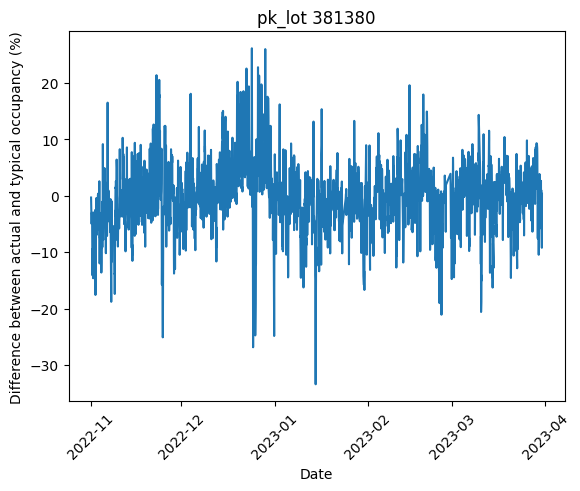

In [109]:
# plot the delta vs. timestamp for first week for random lot
lot_id = np.random.choice(lot_ids)
start_date = '2022-11-01'
end_date = '2023-03-31'
week_df = df[(df['timestamp'] > start_date) & (df['timestamp'] < end_date) & (df['pk_lot'] == lot_id)]
plt.plot(week_df['timestamp'], week_df['delta'])
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Difference between actual and typical occupancy (%)')
plt.title(f'pk_lot {lot_id}')
plt.show()

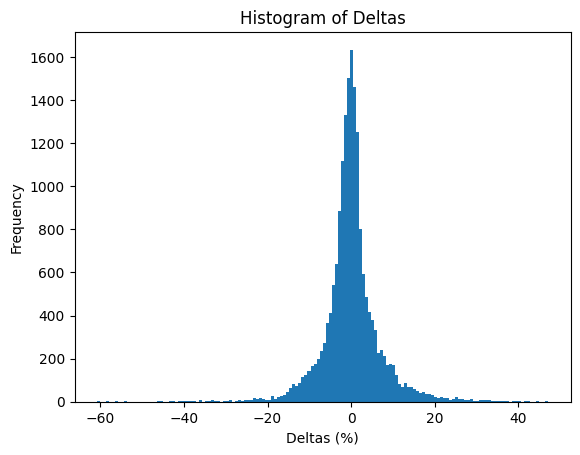

In [110]:
# plot a histogram of all deltas
bins = 150
plt.hist(df['delta'], bins=bins)
plt.xlabel('Deltas (%)')
plt.ylabel('Frequency')
plt.title('Histogram of Deltas')
plt.show()

Mean: 4.911939413334026e-17
Standard Deviation: 7.330106412052062


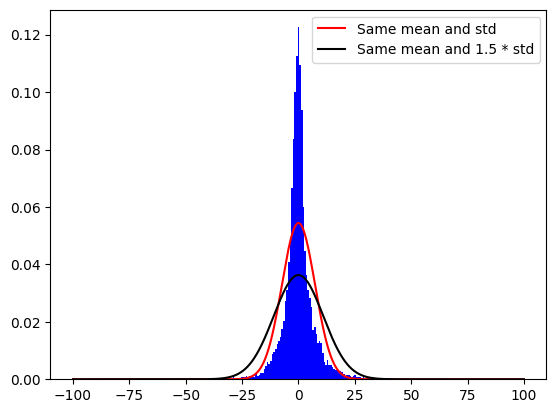

In [111]:
# get the mean and standard deviation
mean = df['delta'].mean()
std = df['delta'].std()
print(f'Mean: {mean}')
print(f'Standard Deviation: {std}')

# plot a normal distribution with the same mean and new standard deviation
x = np.linspace(-100, 100, 1000)
y = normal(x, mean, std)
plt.plot(x, y, color='red', label='Same mean and std')

std_multiplier = 1.5
new_std = std * std_multiplier
x = np.linspace(-100, 100, 1000)
y = (1 / (new_std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / new_std) ** 2)
plt.plot(x, y, color='black', label=f'Same mean and {std_multiplier} * std')

# plot the histogram of deltas
plt.hist(df['delta'], bins=bins, density=True, color='b')
plt.legend()
plt.show()

Resample the data so that the deltas are normally distributed.

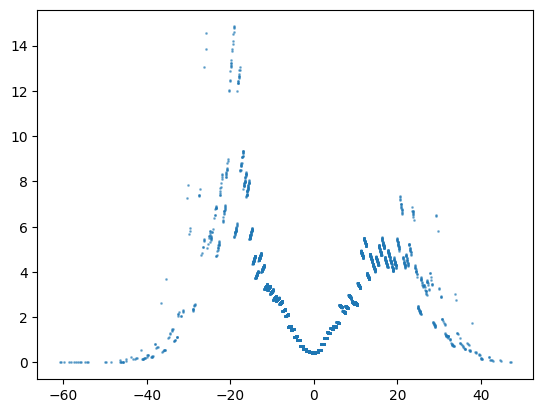

In [112]:
dframe = df.copy()
# given a delta value, how many rows are in the same bin as it?
dframe['bin'] = pd.cut(dframe['delta'], bins=bins, labels=False)
bin_counts = dframe['bin'].value_counts(normalize=True).reset_index()
bin_counts.columns = ['bin', 'bin_percent']

# join the bin_percent to dframe
dframe = pd.merge(dframe, bin_counts, on='bin', how='inner')
# normal distribution
dframe['weight'] = normal(dframe['delta'].values, mean, new_std) / dframe['bin_percent'].values
# uniform  distribution
# dframe['weight'] = 1 / dframe['bin_percent'].values

plt.scatter(dframe['delta'], dframe['weight'], s=1, alpha = 0.5)
plt.show()

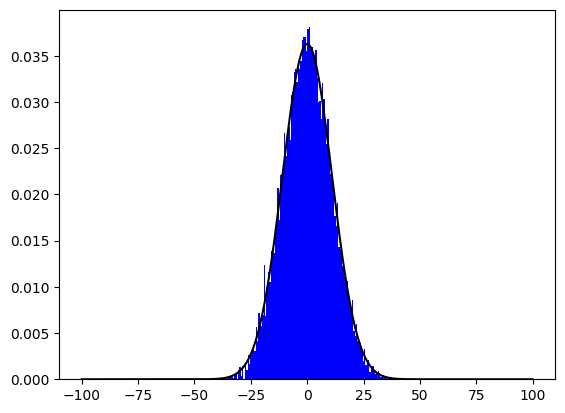

In [113]:
# resample the dframe according to weights
resamp = dframe.copy()
multiplier = 5
resamp = resamp.sample(n=multiplier * dframe.shape[0], replace=True, weights=resamp['weight'])
resamp = resamp.drop(columns=['bin', 'bin_percent', 'weight'])

# plot the histogram of deltas
plt.hist(resamp['delta'], bins=bins, density=True, color='b')
# plt.show()

# plot a normal distribution with the same mean and standard deviation
x = np.linspace(-100, 100, 1000)
y = normal(x, mean, new_std)
plt.plot(x, y, color='black')
plt.show()

In [114]:
resamp.head(5)

,timestamp,pk_lot,wasserstein,avg_hotspot_distance,avg_log_prob,weighted_hotspot_distance,weighted_log_prob,probe_count,nth_car_time,f_pct_occ,i_avail,i_occ,location,geometry,hour,day_of_week,is_weekend,typical_f_pct_occ,hour_of_week,delta
14703,2023-03-01 14:00:00-08:00,381380,0.902504,0.028448,13.615534,0.028121,13.461710,5,103.0,65.0,69.0,NaN,POINT(-117.74155545543 33.6509462183159),"MULTIPOLYGON (((-117.741726902 33.650923943, -...",14,2,False,73.083333,62,-8.083333
3978,2022-12-03 11:00:00-08:00,329825,0.734702,0.014174,14.104441,0.014181,14.182503,4,118.0,75.0,60.0,NaN,POINT(-117.742706 33.6479646),"MULTIPOLYGON (((-117.74335 33.64835, -117.7420...",11,5,True,69.575000,131,5.425000
18450,2023-03-30 14:00:00-07:00,329825,0.767610,0.013467,14.141892,0.012686,14.156919,4,149.0,80.0,49.0,NaN,POINT(-117.742706 33.6479646),"MULTIPOLYGON (((-117.74335 33.64835, -117.7420...",14,3,False,74.691667,86,5.308333
14228,2023-02-24 14:00:00-08:00,380308,0.825475,0.017538,13.721347,0.016903,13.696952,1,110.0,66.0,315.5,NaN,POINT(-117.744096689923 33.6488428962109),"MULTIPOLYGON (((-117.744053131 33.649582084, -...",14,4,False,80.092105,110,-14.092105
17767,2023-03-25 09:00:00-07:00,375750,0.671816,0.024282,14.219649,0.024131,14.317858,2,754.0,18.0,182.0,NaN,POINT(-117.7398482 33.6484276),"MULTIPOLYGON (((-117.74027 33.64827, -117.7402...",9,5,True,22.114583,129,-4.114583


Old size: 2007, New size: 262


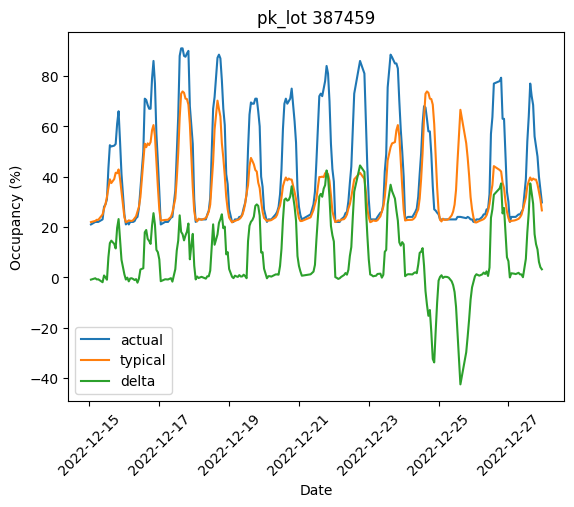

In [115]:
# plot the f_pct_occ vs. timestamp for first week for random lot
lot_id = np.random.choice(lot_ids)
start_date = '2022-12-15'
end_date = '2022-12-28'
week_df = resamp[(resamp['timestamp'] > start_date) & (resamp['timestamp'] < end_date) & (resamp['pk_lot'] == lot_id)].copy()
# drop all duplicates except 1
orig_size = week_df.shape[0]
week_df = week_df.drop_duplicates(subset=['timestamp'], keep='first')
week_df = week_df.sort_values(by=['timestamp'])
new_size = week_df.shape[0]
print(f'Old size: {orig_size}, New size: {new_size}')
plt.plot(week_df['timestamp'], week_df['f_pct_occ'], label='actual')
plt.plot(week_df['timestamp'], week_df['typical_f_pct_occ'], label='typical')
plt.plot(week_df['timestamp'], week_df['delta'], label='delta')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Occupancy (%)')
plt.title(f'pk_lot {lot_id}')
plt.legend()
plt.show()

### Need to be more careful about train/test split (and use XGBoost)

In [116]:
df = resamp.copy()

In [117]:
input_features = ['hour', 'wasserstein', 'avg_hotspot_distance', 'day_of_week', 'avg_log_prob']
# input_features = ['hour', 'day_of_week']
# input_features = ['hour', 'wasserstein', 'weighted_hotspot_distance', 'day_of_week', 'weighted_log_prob']
# input_features = ['hour', 'wasserstein', 'avg_hotspot_distance', 'day_of_week', 'avg_log_prob', 'probe_count', 'nth_car_time']
# input_features = ['wasserstein', 'avg_hotspot_distance', 'day_of_week', 'avg_log_prob']
output_feature = 'f_pct_occ'
# output_feature = 'delta'

test_day = '2023-03-15'  # set aside some weeks for testing
test_lots = [381381]  # set aside some lots that are never seen during training
df_train = df[(df['timestamp'] < test_day) & (~df['pk_lot'].isin(test_lots))].copy()
time_test = df[df['timestamp'] >= test_day].copy()
lot_test = df[df['pk_lot'].isin(test_lots)].copy()

X_train = df_train[input_features].values
y_train = df_train[output_feature].values
X_time_test = time_test[input_features].values
y_time_test = time_test[output_feature].values
X_lot_test = lot_test[input_features].values
y_lot_test = lot_test[output_feature].values

train_size = len(X_train)
time_test_size = len(X_time_test)
lot_test_size = len(X_lot_test)
print(f'Train size: {train_size}, Time Test size: {time_test_size}, Lot Test size: {lot_test_size}')
print(f'{train_size / (train_size + time_test_size + lot_test_size) * 100:.2f}% training data')

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_time_test = scaler.transform(X_time_test)
X_lot_test = scaler.transform(X_lot_test)

# model = RandomForestRegressor(n_estimators=2000, max_depth=50)
model = XGBRegressor(
    n_estimators=1300,
    learning_rate=0.01,
    max_depth=6,
    min_child_weight=3,
    subsample=0.6,
    colsample_bytree=1,
    alpha=0.01,
)
print(model)
model.fit(X_train, y_train)

# evaluate on unseen times
y_time_pred = model.predict(X_time_test)
time_mse = mean_squared_error(y_time_test, y_time_pred)
print(f'Time MSE: {time_mse}')
time_r2 = r2_score(y_time_test, y_time_pred)
print(f'Time R^2: {time_r2}')

# evaluate on unseen lots
y_lot_pred = model.predict(X_lot_test)
lot_mse = mean_squared_error(y_lot_test, y_lot_pred)
print(f'Lot MSE: {lot_mse}')
lot_r2 = r2_score(y_lot_test, y_lot_pred)
print(f'Lot R^2: {lot_r2}')

Train size: 69009, Time Test size: 9348, Lot Test size: 15496
73.53% training data
XGBRegressor(alpha=0.01, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1300,
             n_jobs=None, num_parallel_tree=None, ...)
Time MSE: 165.68579259184114
Time R^2: 0.7106919821036727
Lot MSE: 343.27974171297893
Lot R^2: 0.39689345699789946


In [118]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [750, 1000, 2000],
#     'learning_rate': [0.001, 0.01, 0.05],
#     'subsample': [0.6, 0.8],
#     'colsample_bytree': [0.8, 1.0],
# }

# grid_search = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     scoring='neg_mean_squared_error',
#     cv=3,
#     verbose=3,
#     n_jobs=-1
# )

# grid_search.fit(X_train, y_train)
# print("Best parameters found: ", grid_search.best_params_)

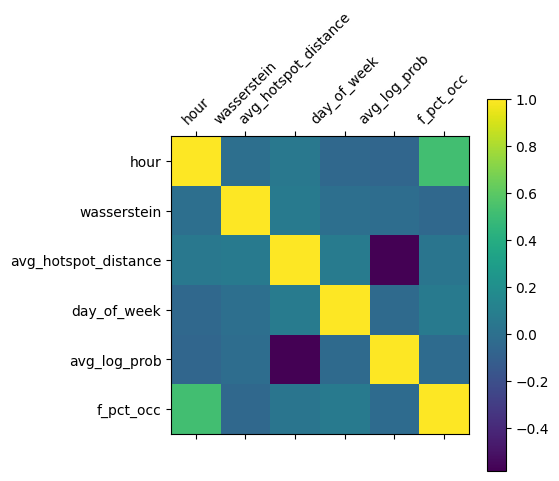

In [119]:
# plot a correlation matrix between the input features and the output feature
corr = df[input_features + [output_feature]].corr()
plt.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.show()


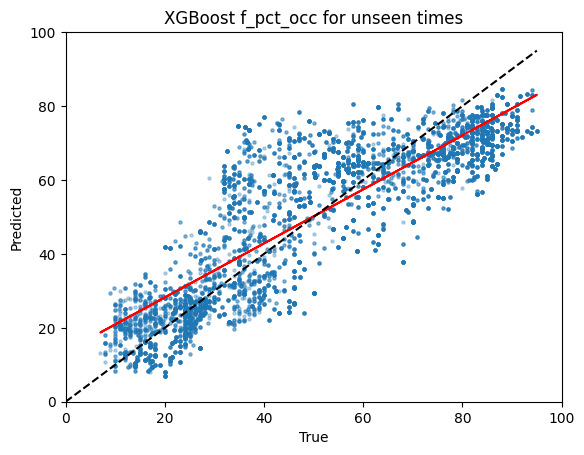

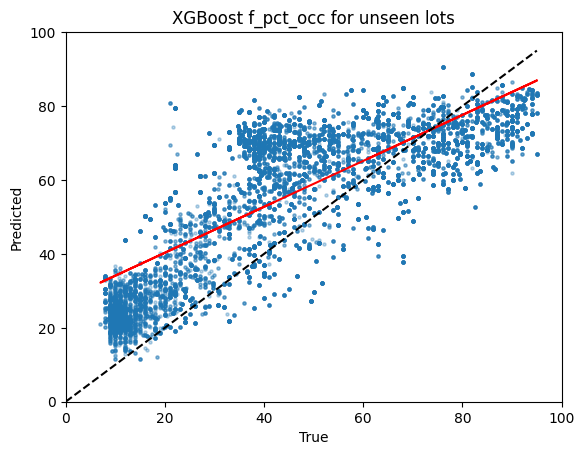

[('hour', 0.7390127), ('wasserstein', 0.044939872), ('avg_hotspot_distance', 0.059674505), ('day_of_week', 0.08058987), ('avg_log_prob', 0.07578299)]


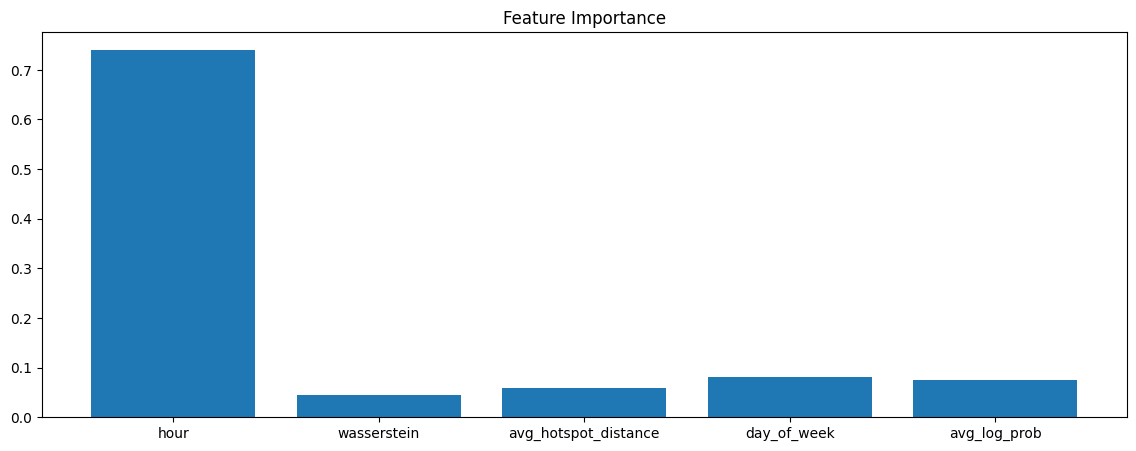

In [120]:
# visualize time results
plt.scatter(y_time_test, y_time_pred, s=5, alpha=0.3)
# line of best fit
m, b = np.polyfit(y_time_test, y_time_pred, 1)
plt.plot(y_time_test, m*y_time_test + b, color='red')
max_val = max(max(y_time_test), max(y_time_pred))
plt.plot([0, max_val], [0, max_val], color='black', linestyle='--')
if output_feature == 'f_pct_occ':
    plt.xlim(0, 100)
    plt.ylim(0, 100)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title(f'XGBoost {output_feature} for unseen times')
plt.show()

# visualize lot results
plt.scatter(y_lot_test, y_lot_pred, s=5, alpha=0.3)
# line of best fit
m, b = np.polyfit(y_lot_test, y_lot_pred, 1)
plt.plot(y_lot_test, m*y_lot_test + b, color='red')
max_val = max(max(y_lot_test), max(y_lot_pred))
plt.plot([0, max_val], [0, max_val], color='black', linestyle='--')
if output_feature == 'f_pct_occ':
    plt.xlim(0, 100)
    plt.ylim(0, 100)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title(f'XGBoost {output_feature} for unseen lots')
plt.show()

# plot feature importance
fig = plt.figure(figsize=(14, 5))
importance = model.feature_importances_
print([(f, i) for f, i in zip(input_features, importance)])
plt.bar([x for x in range(len(importance))], importance)
plt.xticks(ticks=[x for x in range(len(importance))], labels=input_features)
plt.title('Feature Importance')
plt.show()

Predicted time series for pk_lot 381380 from 2023-03-07 to 2023-03-31


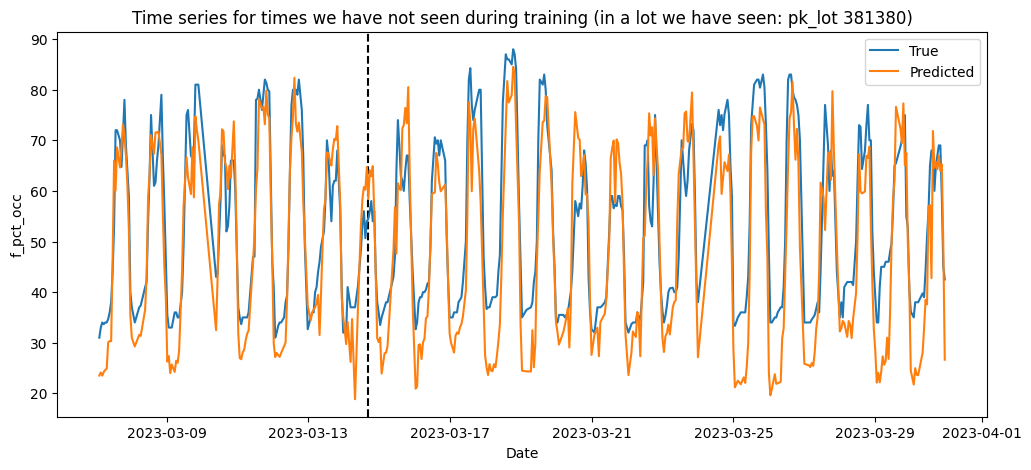

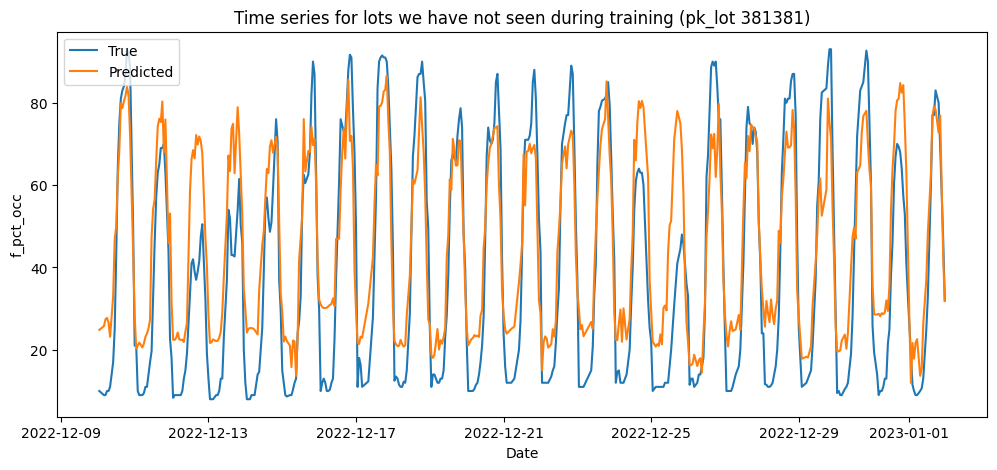

In [121]:
# plot the predicted time series for unseen time data
# get the first week of data for a random lot that we were trained on
train_lots = list(set(lot_ids) - set(test_lots))
lot_id = np.random.choice(train_lots)
start_date = '2023-03-07'
end_date = '2023-03-31'
week_df = df[(df['timestamp'] < end_date) & (start_date < df['timestamp']) & (df['pk_lot'] == lot_id)]
# sort week_df
week_df = week_df.sort_values(by=['timestamp'])
week = week_df[input_features].values
week = scaler.transform(week)
week_pred = model.predict(week)

print(f'Predicted time series for pk_lot {lot_id} from {start_date} to {end_date}')

fig = plt.figure(figsize=(12, 5))
# put a vertical line at test_day if the test_day is bteween strat_date and end_date
if start_date <= test_day <= end_date:
    plt.axvline(x=pd.to_datetime(test_day), color='black', linestyle='--')
plt.plot(week_df['timestamp'], week_df[output_feature], label='True')
plt.plot(week_df['timestamp'], week_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel(output_feature)
plt.title(f'Time series for times we have not seen during training (in a lot we have seen: pk_lot {lot_id})')
plt.legend()
plt.show()


# plot the predicted time series for unseen lot data
lot_id = np.random.choice(test_lots)
start_date = '2022-12-10'
end_date = '2023-01-02'
week_df = df[(df['timestamp'] < end_date) & (start_date < df['timestamp']) & (df['pk_lot'] == lot_id)]
# sort week_df
week_df = week_df.sort_values(by=['timestamp'])
week = week_df[input_features].values
week = scaler.transform(week)
week_pred = model.predict(week)

fig = plt.figure(figsize=(12, 5))
# put a vertical line at test_day if the test_day is bteween strat_date and end_date
if start_date <= test_day <= end_date:
    plt.axvline(x=pd.to_datetime(test_day), color='black', linestyle='--')
plt.plot(week_df['timestamp'], week_df[output_feature], label='True')
plt.plot(week_df['timestamp'], week_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel(output_feature)
plt.title(f'Time series for lots we have not seen during training (pk_lot {lot_id})')
plt.legend()
plt.show()


The model can predict into the future well but does not do well on unseen parking lots. This is likely because each parking lot has different typical trends...

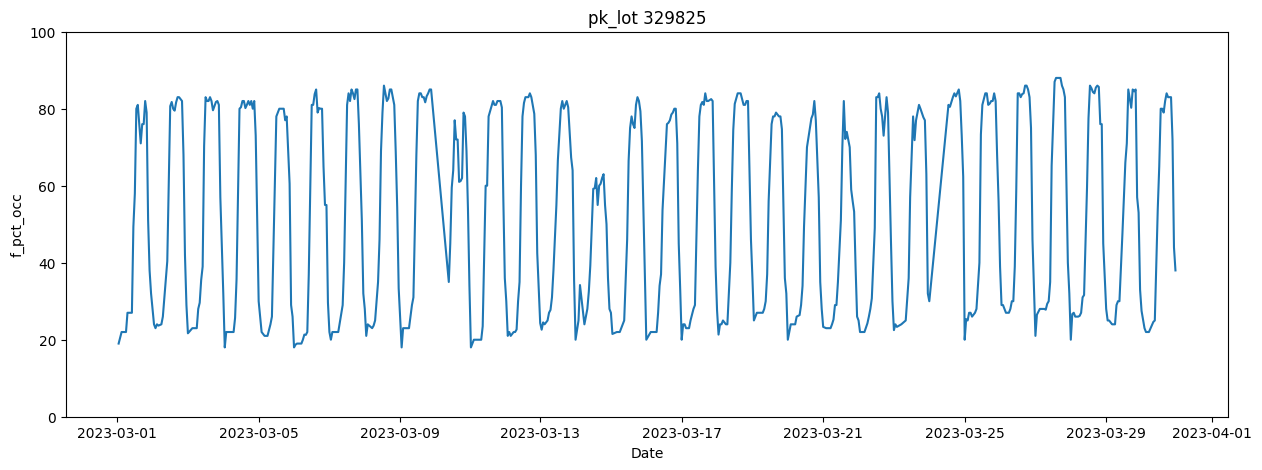

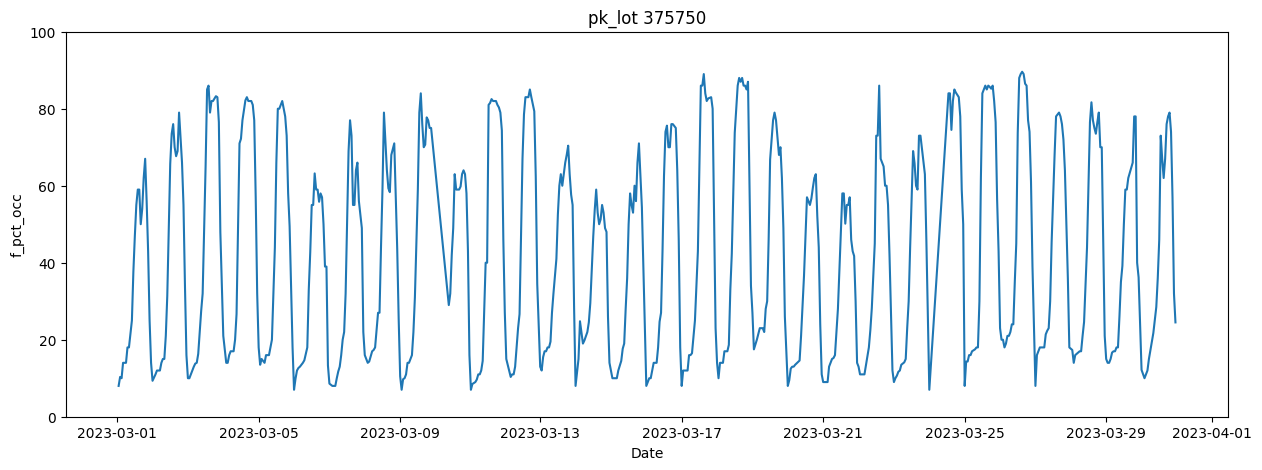

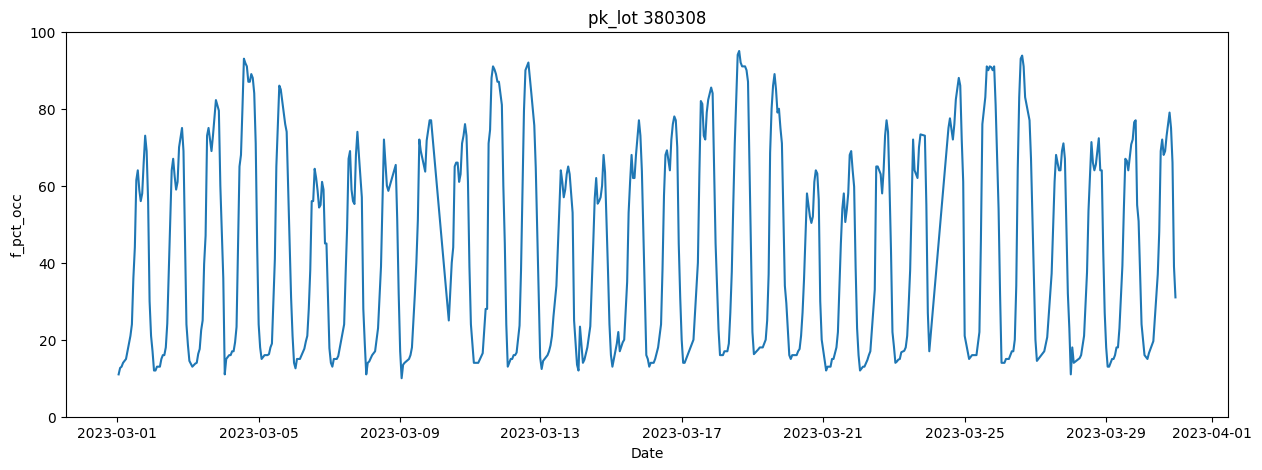

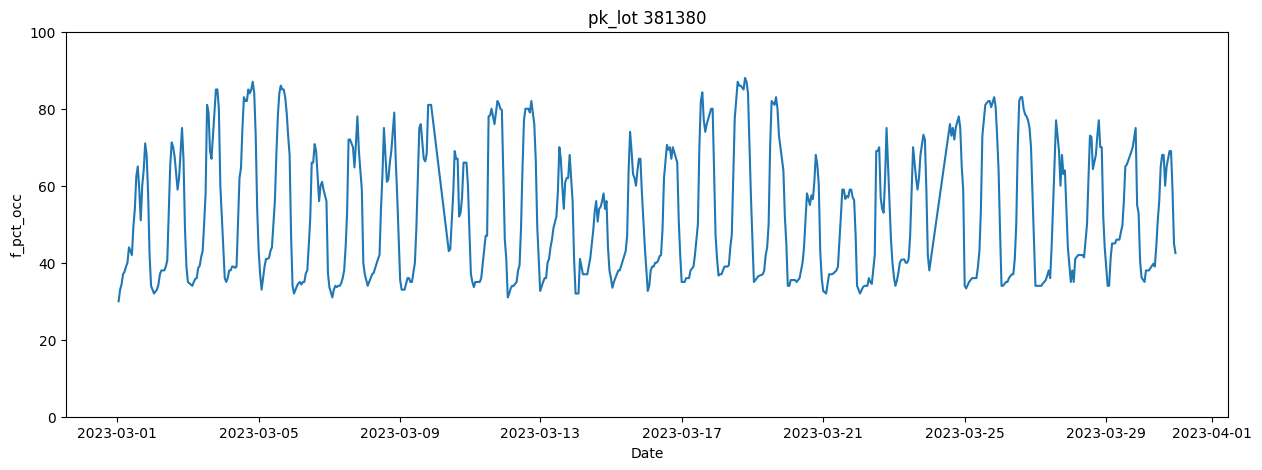

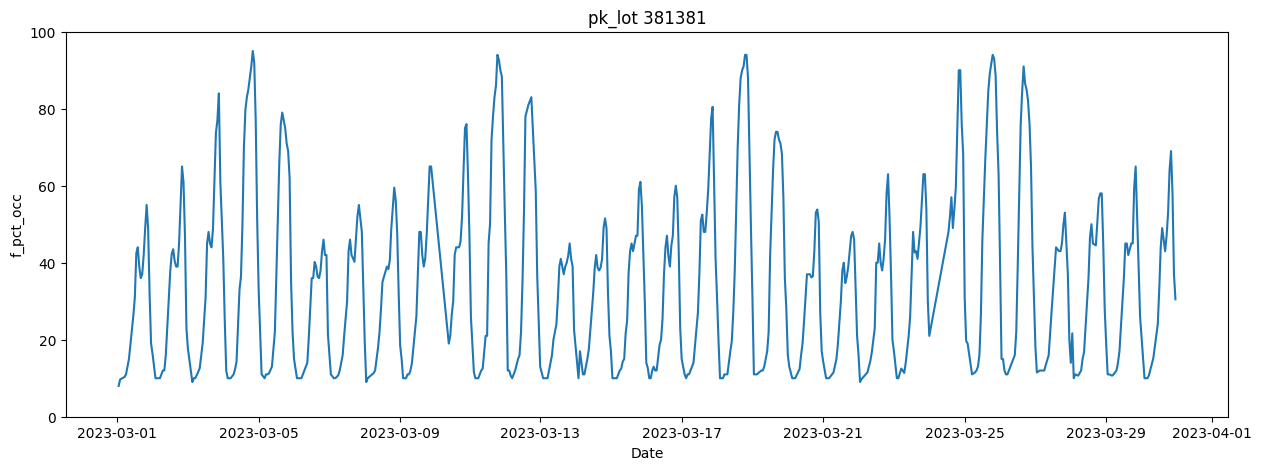

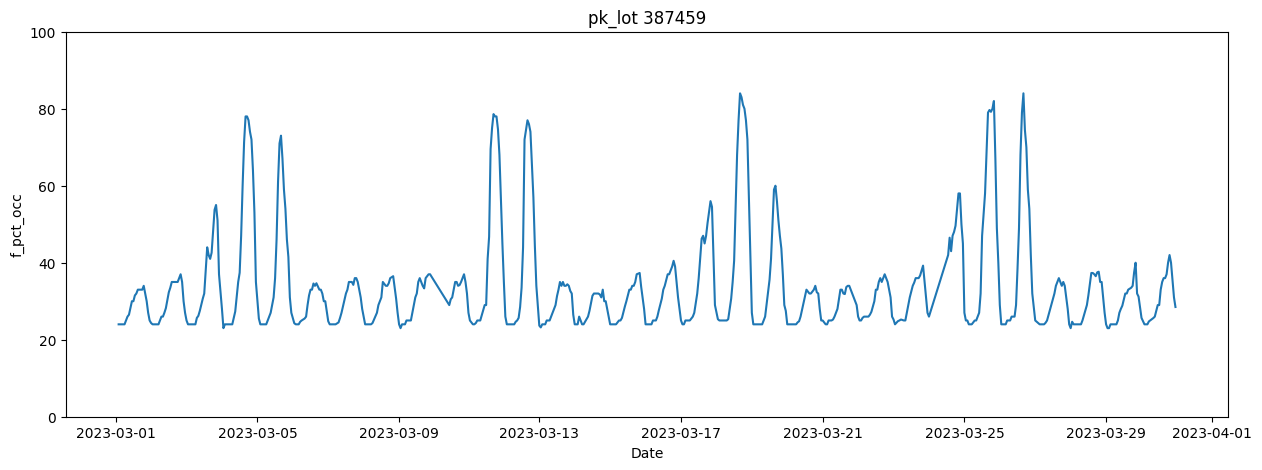

In [122]:
# plot a month of ground truth data for each parking lot
for lot_id in lot_ids:
    fig = plt.figure(figsize=(15, 5))
    week_df = df[(df['timestamp'] < '2023-03-31') & ('2023-03-01' < df['timestamp']) & (df['pk_lot'] == lot_id)].copy()
    week_df = week_df.sort_values(by=['timestamp'])
    week_df = week_df.drop_duplicates(subset=['timestamp'], keep='first')
    plt.plot(week_df['timestamp'], week_df['f_pct_occ'], label='True')
    plt.xlabel('Date')
    plt.ylabel(output_feature)
    plt.title(f'pk_lot {lot_id}')
    plt.ylim(0, 100)
    plt.show()